## Original version

[ WARN:1] global ../modules/videoio/src/cap_gstreamer.cpp (961) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


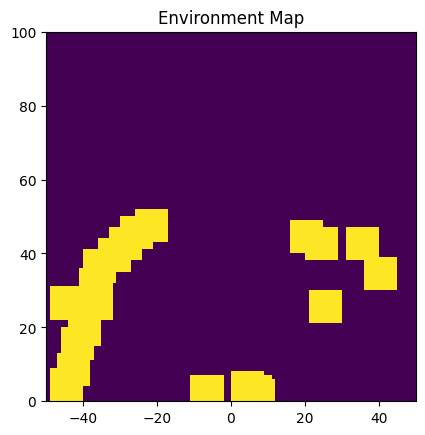

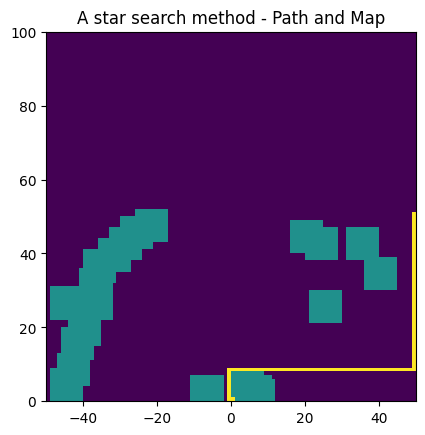

[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_sign: False]
[has_person: False], [has_stop_s

In [ ]:
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import picar_4wd as fc


import sys
import cv2
from tflite_support.task import core
from tflite_support.task import processor
from tflite_support.task import vision
import utils
import threading




Location = tuple[int, int]
# Size of 2D Numpy Array
NP_ARRAY_SIZE = 100

# If below the threshold connect the coordinates
THRESHOLD = 1

SERVO_STEP = 5

# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

global TURN_SPEED
global SPEED
global STOP_TIME
global TURN_TIME
global has_stop_sign, has_person

has_stop_sign = False
has_person = False

SPEED = 20
TURN_SPEED = 30
STOP_TIME = 0.15
TURN_TIME = 1.15

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)

global ENV_MAP

ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))


def get_distance():
    number_distance_readings = 0
    while number_distance_readings < MAX_DISTANCE_READINGS:
        distance = us.get_distance()
        if distance != -2:
            break
        number_distance_readings += 1
    return distance


def get_dergee_distance():
    
    degree_distance_list = []
    for degree in range(-90, 95, SERVO_STEP):
        servo.set_angle(degree)
        time.sleep(0.3)
        distance = get_distance()
        degree_distance_list.append((degree, distance))
        
    return degree_distance_list

def init_map(degree_distance_list: list) -> list:
    
    global ENV_MAP

    ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))
    
    prev_coord = np.array([-100000, -100000])
    
    for degree, distance in degree_distance_list:
        
        x_val = round(distance*np.cos(np.radians(degree + 90)))
        y_val = round(distance*np.sin(np.radians(degree + 90)))
        
        if abs(x_val) >= 50 or y_val >= 50 or y_val <= 0:
            continue

        
        # Ensuring y indices are within bounds
        for dy in range(-4, 5):  # From y_val - 2 to y_val + 2
            y_index = y_val + dy
            if 0 <= y_index and y_index< NP_ARRAY_SIZE:
                # Ensuring x indices are within bounds
                x_start = max(x_val + 46, 0)  # Ensure x_start is not less than 0
                x_end = min(x_val + 55, NP_ARRAY_SIZE)  # Ensure x_end does not exceed NP_ARRAY_SIZE
                ENV_MAP[y_index, x_start:x_end] = 1

        
        present_coord = np.array([x_val, y_val])
        relative_distance = calculate_distance(prev_coord, present_coord)
        
        if relative_distance <= 4:
            interpolate_map(prev_coord, present_coord)
            
        prev_coord = present_coord
        

def calculate_distance(prev_coord, present_coord):
    return np.linalg.norm(prev_coord - present_coord)
        
def interpolate_map(prev_coord, present_coord):
    diff_coord = prev_coord - present_coord
    if diff_coord[0] == 0:
        return
    slope = diff_coord[1] / diff_coord[0]
    for x in range(min(present_coord[0], prev_coord[0]) + 1, max(present_coord[0], prev_coord[0])):
        y = round(slope * (x - present_coord[0]) + present_coord[1])
        ENV_MAP[y][x + 50] = 1
    
def plot_map():
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]

    plt.title("Environment Map")
    plt.imshow(ENV_MAP, interpolation="none", extent=extent, origin="lower")
    plt.show()

def heuristic(a: Location, b: Location) -> float:
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def get_neighbors(grid: np.ndarray, current: Location) -> list[Location]:
    (x, y) = current
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]  # 4-directional movement
    valid_neighbors = [n for n in neighbors if 0 <= n[0] < grid.shape[0] and 0 <= n[1] < grid.shape[1] and grid[n] == 0]
    return valid_neighbors

def a_star_search(grid: np.ndarray, start: Location, goal: Location):
    frontier = PriorityQueue()
    frontier.put((0, start))  # Priority queues require a tuple (priority, item)
    came_from: dict[Location, Location | None] = {}
    cost_so_far: dict[Location, float] = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current_priority, current = frontier.get()
        
        if current == goal:
            break
        
        for next in get_neighbors(grid, current):
            new_cost = cost_so_far[current] + 1  # Assume a uniform cost of 1 for simplicity
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put((priority, next))
                came_from[next] = current
    
    return came_from, cost_so_far

def reconstruct_path(came_from: dict[Location, Location or None], start: Location, goal: Location) -> list[Location]:
    current = goal
    path = []
    while current != start:  # backtrack from goal to start
        path.append(current)
        current = came_from[current]
    path.append(start)  # optional: add start position
    path.reverse()  # optional: reverse the path to start->goal
    return path

def visualize_path(grid: np.ndarray, path: list[Location]):
    # Mark the path in the grid for visualization
    for location in path:
        grid[location] = 2  # Mark the path with 2

    
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]
    # Plot the grid
    plt.title("A star search method - Path and Map")
    plt.imshow(grid, interpolation='nearest', origin='lower', extent=extent)
    plt.show()
    
def get_directions(path: list) -> list:
    directions = []
    for i in range(1, len(path)):
        current = path[i]
        previous = path[i-1]
        if current[0] == previous[0]:
            if current[1] == previous[1] + 1:
                directions.append('Right')
            else:
                directions.append('Left')
        else:
            if current[0] == previous[0] + 1:
                directions.append('Down')
            else:
                directions.append('Up')
    return directions
    

def navigate_with_path(path: list):
    
    global SPEED
    global STOP_TIME
    global TURN_TIME
    global TURN_SPEED, has_person, has_stop_sign

    prev_direction = path[0]
    if prev_direction == 'Right':
        fc.turn_left(TURN_SPEED)
        time.sleep(TURN_TIME)
    elif prev_direction == 'Left':
        fc.turn_right(TURN_SPEED)
        time.sleep(TURN_TIME)
    for curr_direction in path:

        print(f'[has_person: {has_person}], [has_stop_sign: {has_stop_sign}]')
        
        while has_person or has_stop_sign:
            print(f'[has_person: {has_person}], [has_stop_sign: {has_stop_sign}]')
            fc.stop()
            time.sleep(1)
        
        if prev_direction == curr_direction:
            if prev_direction == "Right" or prev_direction == "Left":
                fc.forward(SPEED)
                time.sleep(0.02)
            else:
                fc.forward(SPEED)
                time.sleep(0.05)
        else:
            if (prev_direction == 'Right' and curr_direction == 'Down') or (prev_direction == 'Left' and curr_direction == 'Up') or (prev_direction == 'Down' and curr_direction == 'Left') or (prev_direction == 'Up' and curr_direction == 'Right'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_right(TURN_SPEED)
                time.sleep(TURN_TIME)
            elif (prev_direction == 'Right' and curr_direction == 'Up') or (prev_direction == 'Left' and curr_direction == 'Down') or (prev_direction == 'Down' and curr_direction == 'Right') or (prev_direction == 'Up' and curr_direction == 'Left'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_left(TURN_SPEED)
                time.sleep(TURN_TIME)
            
        prev_direction = curr_direction
        
def object_detection(model: str, camera_id: int, width: int, height: int, num_threads: int,
        enable_edgetpu: bool) -> None:
    """Continuously run inference on images acquired from the camera.

    Args:
    model: Name of the TFLite object detection model.
    camera_id: The camera id to be passed to OpenCV.
    width: The width of the frame captured from the camera.
    height: The height of the frame captured from the camera.
    num_threads: The number of CPU threads to run the model.
    enable_edgetpu: True/False whether the model is a EdgeTPU model.
    """
    
    global detection_list, has_person, has_stop_sign

    # Variables to calculate FPS

    counter, fps = 0, 0
    start_time = time.time()

    # Start capturing video input from the camera
    cap = cv2.VideoCapture(camera_id)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

    # Visualization parameters
    row_size = 20  # pixels
    left_margin = 24  # pixels
    text_color = (0, 0, 255)  # red
    font_size = 1
    font_thickness = 1
    fps_avg_frame_count = 10

    # Initialize the object detection model
    base_options = core.BaseOptions(
      file_name=model, use_coral=enable_edgetpu, num_threads=num_threads)
    detection_options = processor.DetectionOptions(
      max_results=3, score_threshold=0.3)
    options = vision.ObjectDetectorOptions(
      base_options=base_options, detection_options=detection_options)
    detector = vision.ObjectDetector.create_from_options(options)

    # Continuously capture images from the camera and run inference
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            sys.exit(
              'ERROR: Unable to read from webcam. Please verify your webcam settings.'
            )

        # Reset detection flags for each frame
        has_stop_sign = False
        has_person = False
        
        counter += 1
        image = cv2.flip(image, -1)

        # Convert the image from BGR to RGB as required by the TFLite model.
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create a TensorImage object from the RGB image.
        input_tensor = vision.TensorImage.create_from_array(rgb_image)

        # Run object detection estimation using the model.
        detection_results = detector.detect(input_tensor)

        for detection in detection_results.detections:
            category = detection.categories[0]
            class_name = category.category_name
            if class_name == 'stop sign':
                has_stop_sign = True
            if class_name == 'person':
                has_person = True

        # Draw keypoints and edges on input image
        image = utils.visualize(image, detection_results)

        # Calculate the FPS
        if counter % fps_avg_frame_count == 0:
            end_time = time.time()
            fps = fps_avg_frame_count / (end_time - start_time)
            start_time = time.time()

        # Show the FPS
        fps_text = 'FPS = {:.1f}'.format(fps)
        text_location = (left_margin, row_size)
        cv2.putText(image, fps_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                    font_size, text_color, font_thickness)

        # Stop the program if the ESC key is pressed.
        if cv2.waitKey(1) == 27:
            break
        cv2.imshow('object_detector', image)


    cap.release()
    cv2.destroyAllWindows()
    
            

def main():


    # degree_distance_list = get_dergee_distance()
    # init_map(degree_distance_list)
    # plot_map()
    # servo.set_angle(0)

    global TURN_SPEED, SPEED, detection_results, has_person, has_stop_sign
    run_duration = 10
    turn_time = 1.1
    
    start, goal = (0, 50), (50, 99)
    
    detection_thread = threading.Thread(target=object_detection, args=('efficientdet_lite0.tflite', 0, 640, 480,4, False))
    # detection_thread.daemon = True  # Optional: makes the thread exit when the main program exits
    detection_thread.start()
    

    start_time = time.time()
    
    while True:
        
        current_time = time.time()

        if current_time - start_time > run_duration:
            break

        degree_distance_list = get_dergee_distance()
        
        init_map(degree_distance_list)
        plot_map()
        servo.set_angle(0)
        
        grid = ENV_MAP
        came_from, cost_so_far = a_star_search(grid, start, goal)
        
        path = reconstruct_path(came_from, start, goal)
        directions = get_directions(path)
        visualize_path(grid, path)

        navigate_with_path(directions)
        
        fc.stop()
    
    detection_thread.join()
    fc.stop()
    cv2.destroyAllWindows()
    
    
if __name__ == "__main__":
    main()

## Modified version

[ WARN:0] global ../modules/videoio/src/cap_gstreamer.cpp (961) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


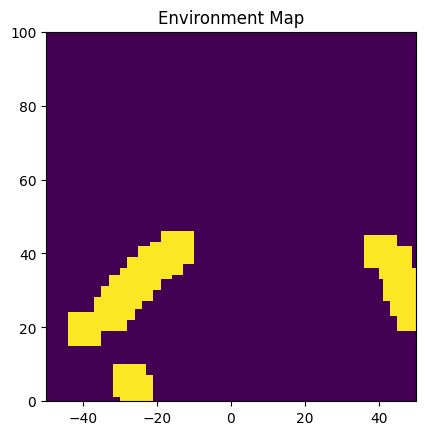

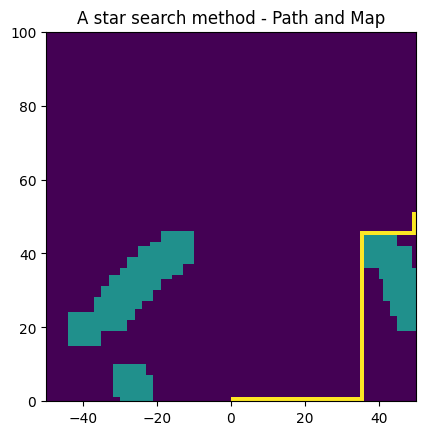

in navigate_with_path: [has_person: False], [has_stop_sign: False] in object_detection: [has_person: False], [has_stop_sign: False]

in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: Fal

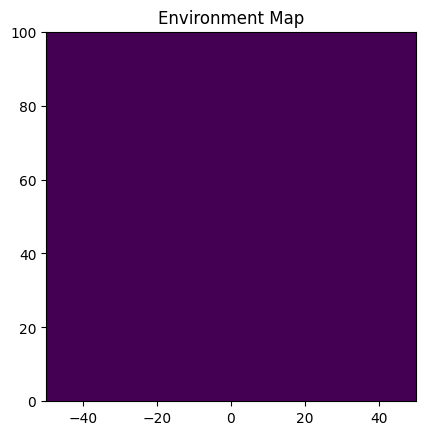

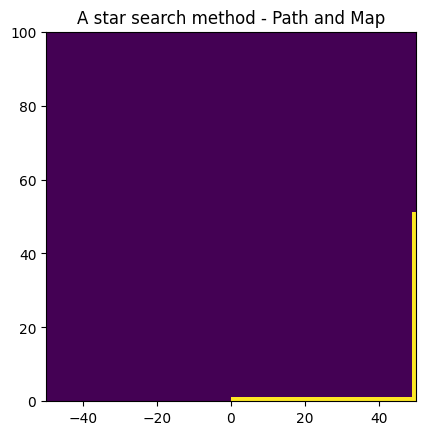

in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: False]
in navigate_with_path: [has_person: False], [has_stop_sign: Fa

In [1]:
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import picar_4wd as fc


import sys
import cv2
from tflite_support.task import core
from tflite_support.task import processor
from tflite_support.task import vision
import utils
import threading




Location = tuple[int, int]
# Size of 2D Numpy Array
NP_ARRAY_SIZE = 100

# If below the threshold connect the coordinates
THRESHOLD = 1

SERVO_STEP = 5

# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

global TURN_SPEED
global SPEED
global STOP_TIME
global TURN_TIME
global has_stop_sign, has_person, NO_DETECTION_THRESHOLD, REACHED

NO_DETECTION_THRESHOLD = 3

REACHED = False
has_stop_sign = False
has_person = False

SPEED = 20
TURN_SPEED = 20
STOP_TIME = 0.15
TURN_TIME = 0.85

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)

global ENV_MAP

ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))


def get_distance():
    number_distance_readings = 0
    while number_distance_readings < MAX_DISTANCE_READINGS:
        distance = us.get_distance()
        if distance != -2:
            break
        number_distance_readings += 1
    return distance


def get_dergee_distance():
    
    degree_distance_list = []
    for degree in range(-90, 95, SERVO_STEP):
        servo.set_angle(degree)
        time.sleep(0.15)
        distance = get_distance()
        degree_distance_list.append((degree, distance))
        
    return degree_distance_list

def init_map(degree_distance_list: list) -> list:
    
    global ENV_MAP

    ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))
    
    prev_coord = np.array([-100000, -100000])
    
    for degree, distance in degree_distance_list:
        
        x_val = round(distance*np.cos(np.radians(degree + 90)))
        y_val = round(distance*np.sin(np.radians(degree + 90)))
        
        if abs(x_val) >= 50 or y_val >= 50 or y_val <= 0:
            continue

        
        # Ensuring y indices are within bounds
        for dy in range(-4, 5):  # From y_val - 2 to y_val + 2
            y_index = y_val + dy
            if 0 <= y_index and y_index< NP_ARRAY_SIZE:
                # Ensuring x indices are within bounds
                x_start = max(x_val + 46, 0)  # Ensure x_start is not less than 0
                x_end = min(x_val + 55, NP_ARRAY_SIZE)  # Ensure x_end does not exceed NP_ARRAY_SIZE
                ENV_MAP[y_index, x_start:x_end] = 1

        
        present_coord = np.array([x_val, y_val])
        relative_distance = calculate_distance(prev_coord, present_coord)
        
        if relative_distance <= 4:
            interpolate_map(prev_coord, present_coord)
            
        prev_coord = present_coord
        

def calculate_distance(prev_coord, present_coord):
    return np.linalg.norm(prev_coord - present_coord)
        
def interpolate_map(prev_coord, present_coord):
    diff_coord = prev_coord - present_coord
    if diff_coord[0] == 0:
        return
    slope = diff_coord[1] / diff_coord[0]
    for x in range(min(present_coord[0], prev_coord[0]) + 1, max(present_coord[0], prev_coord[0])):
        y = round(slope * (x - present_coord[0]) + present_coord[1])
        ENV_MAP[y][x + 50] = 1
    
def plot_map():
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]

    plt.title("Environment Map")
    plt.imshow(ENV_MAP, interpolation="none", extent=extent, origin="lower")
    plt.show()

def heuristic(a: Location, b: Location) -> float:
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def get_neighbors(grid: np.ndarray, current: Location) -> list[Location]:
    (x, y) = current
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]  # 4-directional movement
    valid_neighbors = [n for n in neighbors if 0 <= n[0] < grid.shape[0] and 0 <= n[1] < grid.shape[1] and grid[n] == 0]
    return valid_neighbors

def a_star_search(grid: np.ndarray, start: Location, goal: Location):
    frontier = PriorityQueue()
    frontier.put((0, start))  # Priority queues require a tuple (priority, item)
    came_from: dict[Location, Location | None] = {}
    cost_so_far: dict[Location, float] = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current_priority, current = frontier.get()
        
        if current == goal:
            break
        
        for next in get_neighbors(grid, current):
            new_cost = cost_so_far[current] + 1  # Assume a uniform cost of 1 for simplicity
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put((priority, next))
                came_from[next] = current
    
    return came_from, cost_so_far

def reconstruct_path(came_from: dict[Location, Location or None], start: Location, goal: Location) -> list[Location]:
    current = goal
    path = []
    while current != start:  # backtrack from goal to start
        path.append(current)
        current = came_from[current]
    path.append(start)  # optional: add start position
    path.reverse()  # optional: reverse the path to start->goal
    return path

def visualize_path(grid: np.ndarray, path: list[Location]):
    # Mark the path in the grid for visualization
    for location in path:
        grid[location] = 2  # Mark the path with 2

    
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]
    # Plot the grid
    plt.title("A star search method - Path and Map")
    plt.imshow(grid, interpolation='nearest', origin='lower', extent=extent)
    plt.show()
    
def get_directions(path: list) -> list:
    directions = []
    for i in range(1, len(path)):
        current = path[i]
        previous = path[i-1]
        if current[0] == previous[0]:
            if current[1] == previous[1] + 1:
                directions.append('Right')
            else:
                directions.append('Left')
        else:
            if current[0] == previous[0] + 1:
                directions.append('Down')
            else:
                directions.append('Up')
    return directions
    

def navigate_with_path(path: list):
    
    global SPEED
    global STOP_TIME
    global TURN_TIME
    global TURN_SPEED, has_person, has_stop_sign, REACHED

    prev_direction = path[0]
    if prev_direction == 'Right':
        fc.turn_right(TURN_SPEED)
        time.sleep(TURN_TIME)
    elif prev_direction == 'Left':
        fc.turn_left(TURN_SPEED)
        time.sleep(TURN_TIME)
    for curr_direction in path:

        print(f'in navigate_with_path: [has_person: {has_person}], [has_stop_sign: {has_stop_sign}]')
        
        while has_person or has_stop_sign:
            print(f'[has_person: {has_person}], [has_stop_sign: {has_stop_sign}]')
            fc.stop()
            time.sleep(1)
        
        if prev_direction == curr_direction:
            if prev_direction == "Right" or prev_direction == "Left":
                fc.forward(SPEED)
                time.sleep(0.0005)
            else:
                fc.forward(SPEED)
                time.sleep(0.0023)
        else:
            if (prev_direction == 'Right' and curr_direction == 'Down') or (prev_direction == 'Left' and curr_direction == 'Up') or (prev_direction == 'Down' and curr_direction == 'Left') or (prev_direction == 'Up' and curr_direction == 'Right'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_left(TURN_SPEED)
                time.sleep(TURN_TIME)
            elif (prev_direction == 'Right' and curr_direction == 'Up') or (prev_direction == 'Left' and curr_direction == 'Down') or (prev_direction == 'Down' and curr_direction == 'Right') or (prev_direction == 'Up' and curr_direction == 'Left'):
                fc.stop()
                time.sleep(STOP_TIME)
                fc.turn_right(TURN_SPEED)
                time.sleep(TURN_TIME)
            
        prev_direction = curr_direction

    REACHED = True
        
def object_detection(model: str, camera_id: int, width: int, height: int, num_threads: int,
        enable_edgetpu: bool) -> None:
    """Continuously run inference on images acquired from the camera.

    Args:
    model: Name of the TFLite object detection model.
    camera_id: The camera id to be passed to OpenCV.
    width: The width of the frame captured from the camera.
    height: The height of the frame captured from the camera.
    num_threads: The number of CPU threads to run the model.
    enable_edgetpu: True/False whether the model is a EdgeTPU model.
    """
    
    global has_person, has_stop_sign, NO_DETECTION_THRESHOLD, REACHED

    # Variables to calculate FPS

    counter, fps = 0, 0
    start_time = time.time()

    # Start capturing video input from the camera
    cap = cv2.VideoCapture(camera_id)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

    # Visualization parameters
    row_size = 20  # pixels
    left_margin = 24  # pixels
    text_color = (0, 0, 255)  # red
    font_size = 1
    font_thickness = 1
    fps_avg_frame_count = 10

    # Initialize the object detection model
    base_options = core.BaseOptions(
      file_name=model, use_coral=enable_edgetpu, num_threads=num_threads)
    detection_options = processor.DetectionOptions(
      max_results=3, score_threshold=0.3)
    options = vision.ObjectDetectorOptions(
      base_options=base_options, detection_options=detection_options)
    detector = vision.ObjectDetector.create_from_options(options)

    no_person_counter = 0
    no_stop_sign_counter = 0

    # Continuously capture images from the camera and run inference
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            sys.exit(
              'ERROR: Unable to read from webcam. Please verify your webcam settings.'
            )

        # Reset detection flags for each frame
        # has_stop_sign = False
        # has_person = False

        if REACHED:
            break
        
        counter += 1
        image = cv2.flip(image, -1)

        # Convert the image from BGR to RGB as required by the TFLite model.
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create a TensorImage object from the RGB image.
        input_tensor = vision.TensorImage.create_from_array(rgb_image)

        # Run object detection estimation using the model.
        detection_results = detector.detect(input_tensor)

        person_detected = False
        stop_sign_detected = False
        for detection in detection_results.detections:
            category = detection.categories[0]
            class_name = category.category_name
            if class_name == 'stop sign':
                stop_sign_detected = True
                has_stop_sign = True
                no_stop_sign_counter = 0  # Reset counter because object is detected
            if class_name == 'person':
                person_detected = True
                has_person = True
                no_person_counter = 0  # Reset counter because object is detected
            print(f' in object_detection: [has_person: {has_person}], [has_stop_sign: {has_stop_sign}]')

        # Update counters and flags based on detection
        if not person_detected:
            no_person_counter += 1
        if not stop_sign_detected:
            no_stop_sign_counter += 1

        # Reset flags if objects have not been detected for consecutive frames
        if no_person_counter >= NO_DETECTION_THRESHOLD:
            has_person = False

        if no_stop_sign_counter >= NO_DETECTION_THRESHOLD:
            has_stop_sign = False

        # Draw keypoints and edges on input image
        image = utils.visualize(image, detection_results)

        # Calculate the FPS
        if counter % fps_avg_frame_count == 0:
            end_time = time.time()
            fps = fps_avg_frame_count / (end_time - start_time)
            start_time = time.time()

        # Show the FPS
        fps_text = 'FPS = {:.1f}'.format(fps)
        text_location = (left_margin, row_size)
        cv2.putText(image, fps_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                    font_size, text_color, font_thickness)

        # Stop the program if the ESC key is pressed.
        if cv2.waitKey(1) == 27:
            break
        cv2.imshow('object_detector', image)


    cap.release()
    cv2.destroyAllWindows()
    
            

def main():


    # degree_distance_list = get_dergee_distance()
    # init_map(degree_distance_list)
    # plot_map()
    # servo.set_angle(0)

    global TURN_SPEED, SPEED, detection_results, has_person, has_stop_sign
    run_duration = 40
    turn_time = 1.1
    
    start, goal = (0, 50), (50, 99)
    
    detection_thread = threading.Thread(target=object_detection, args=('efficientdet_lite0.tflite', 0, 640, 480,4, False))
    detection_thread.daemon = True  # Optional: makes the thread exit when the main program exits
    detection_thread.start()
    

    start_time = time.time()
    
    while True:
        
        current_time = time.time()

        if current_time - start_time > run_duration:
            break

        degree_distance_list = get_dergee_distance()
        
        init_map(degree_distance_list)
        plot_map()
        servo.set_angle(0)
        
        grid = ENV_MAP
        came_from, cost_so_far = a_star_search(grid, start, goal)
        
        path = reconstruct_path(came_from, start, goal)
        directions = get_directions(path)
        visualize_path(grid, path)

        navigate_with_path(directions)
        
        fc.stop()
    
    detection_thread.join()
    fc.stop()
    cv2.destroyAllWindows()
    
    
if __name__ == "__main__":
    main()